# **CIS 5190 Final Project: Gendered Pathways in Science: Exploring the Impact of Researcher Gender on Academic Success**

**Team Member:**
- Karol Korl
- Deniel Shumeiko
- Zed Liu


# **Part 1: Introduction**

## **Task**

We propose a project in which we are going to predict the academic success of researchers (e.g. H-index, total citations, PageRank, etc.) based on the features of their publication statistics and personal information, with a focus on the effect of researcher’s biological sex (gender) on the chosen metric of success.

## **Experience**

To conduct this research, we will use web scraping technics to build our own dataset about academic information of researchers in **Human Computer Interaction (HCI)** domain, and will run different machine learning models (i.e. linear regression and neural networks with various architectures) to predict their h-index.

In detials, our dataset will contain features such as `I10-index`, `Total Citations`, `Citations in Last 5 Years`, `Gender`, `Title`, `Affliation`, `Country`, `Total Number of Publications` and `Max Citation`, while the `H-index` will be our target value.

After collecting the data, we will feed the data into a series of tradition ML models (e.g. linear regression with regulations, random forest, ect.) as our baseline, and try to build a more advanced Feed Forward Neural Network to improve the prediction performance.

## **Performance Metrics**

 To evaluate the performance of the model, we are planning to use $R^2$ or the value of the Mean Square Error (MSE) cost of the prediction.

## **Prior Works**

1. Lucaweihs. (n.d.). Lucaweihs/Impact-prediction: Predict author h-index and Paper Citation Counts on the dataset underlying semanic scholar. GitHub. https://github.com/Lucaweihs/impact-prediction

2. Acuna, D., Allesina, S. & Kording, K. Predicting scientific success. Nature 489, 201–202 (2012). https://doi.org/10.1038/489201a

3. Xiangjie Kong, Jun Zhang, Da Zhang, Yi Bu, Ying Ding, and Feng Xia. 2020. The Gene of Scientific Success. ACM Trans. Knowl. Discov. Data 14, 4, Article 41 (August 2020), 19 pages. https://doi.org/10.1145/3385530

## **Nature of main proposed contributions**

1. Collect and build dataset about researchers and publication information in HCI domain using web scraping technics.

2. Introduce advance machine learning model into such as FNN into h-index prediction for the first time.

3. Help researchers to better understand to driving factor behind the H-index.

4. Evaluation the gender equality in researching.

## Import and Setup

Run following cell to get access of the Google drive, where we store the scraping data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install necessary library for future processing and modeling.

In [ ]:
!python -m spacy download en_core_web_lg
!pip install gender-guesser
!pip install fuzzywuzzy
!pip install rapidfuzz
!pip install scholarly
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

Install necessary library for future processing and modeling.

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from scholarly import scholarly
import requests
import json
import spacy
from gender_guesser.detector import Detector
import random

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

from rapidfuzz import process, fuzz
import concurrent.futures

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import AdaBoostRegressor
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit

import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# **Part 2: Data Scarping from Web**

In this section, we scape infroamtion of researchers in HCI domain from Google Scholar using `Schalarly` library in Python.

[Scholarly](https://pypi.org/project/scholarly/) is a module that allows us to retrieve author and publication information from [Google Scholar](https://scholar.google.com/) in a friendly, Pythonic way without having to solve CAPTCHAs.

Here, we first define a function called `fetch_scholars` to scrape information about a searcher according to certain keywords. This function will automatically get the a list of relavent researchers and storge their personal and publications information in `scholars.csv` and `Publications.csv` in a formated way.

In conclusion, by implementing `Scholarly API`, we devdelop a elegent way to scrape researchers information from Google Scholar. This tool can actually be used in different researching setting, not limited to this every project.

> Since it will take about **24 hours** to scrape the relavant data, we comment out the web scraping code and directly load the csv files from Google Drive.

In [ ]:
# # Import the scholarly module to interact with Google Scholar data
# from scholarly import scholarly

# # Define the function fetch_scholars which accepts a keyword to search for relevant scholars
# def fetch_scholars(keyword):
#     # Perform a keyword search on Google Scholar and initialize lists to store data
#     search_query = scholarly.search_keyword(keyword)
#     scholars_list = []
#     publications_list = []
#     count = 0

#     # Iterate over each scholar found in the search query
#     for scholar in search_query:
#         try:
#             # Fill detailed information about the scholar including publications
#             scholar_filled = scholarly.fill(scholar, sections=['basics', 'indices', 'counts', 'public_access', 'publications'])

#             # Organize important scholar information into a dictionary
#             scholar_data = {
#                 'Name': scholar_filled['name'],
#                 'Affiliation': scholar_filled.get('affiliation', 'N/A'),
#                 'H-index': scholar_filled['hindex'],
#                 'I10-index': scholar_filled['i10index'],
#                 'Total Citations': scholar_filled['citedby'],
#                 'Citations in Last 5 Years': scholar_filled.get('citedby5y', 'N/A'),
#                 'Public Access Paper (Available)': scholar_filled['public_access']['available'],
#                 'Public Access Paper (Not Available)': scholar_filled['public_access']['not_available']
#             }
#             scholars_list.append(scholar_data)
#             print(count+1, end=":")
#             print(scholar_data)

#             # Collect publication data from the scholar's publications
#             for publication in scholar_filled.get('publications', []):
#                 pub_data = {
#                     'Author Name': scholar_filled['name'],
#                     'Title': publication['bib']['title'],
#                     'Year': publication['bib'].get('pub_year', 'N/A'),
#                     'Citations': publication.get('num_citations', 0)
#                 }
#                 publications_list.append(pub_data)

#             # Increment the counter for each processed scholar
#             count += 1

#             # Every 100 scholars, save the data to a CSV file and reset the lists
#             if count % 100 == 0:
#                 scholars_df = pd.DataFrame(scholars_list)
#                 scholars_df.to_csv(f"/content/drive/My Drive/scholars_data_{count}.csv", index=False)
#                 publication_df = pd.DataFrame(publications_list)
#                 publication_df.to_csv(f"/content/drive/My Drive/publications_data_{count}.csv", index=False)
#                 scholars_list = []
#                 publications_list = []

#         except Exception as e:
#             # If an error occurs during processing, print the error message
#             print(f"Failed to process scholar: {e}")

# # Define the keyword to search for and call the fetch_scholars function
# keyword = 'human-computer interaction'
# fetch_scholars(keyword)

# **Part 3: Data Loading and Preprocessing**

In this section, we load the arlready-scraped the datasets and prepeocssing them in the following pipeline: $cleaning\ →\ encoding\ →\ merging $.

**Our main database sources include:**
- Scraped Scholar Data: https://drive.google.com/drive/folders/1fxFaiJAO07zdNvarrUMzSe5DpNp0umFg?usp=share_link

- Scraped Publication Data: https://drive.google.com/drive/folders/1fxFaiJAO07zdNvarrUMzSe5DpNp0umFg?usp=share_link

- 2024 QS World University Ranking: https://www.kaggle.com/datasets/joebeachcapital/qs-world-university-rankings-2024


## **3.1 Scholar Dataset**

First, we load the scraped scholar data from [Google Drive Folder](https://drive.google.com/drive/folders/1fxFaiJAO07zdNvarrUMzSe5DpNp0umFg?usp=share_link), and store all the data in a pandas data set called `scholars`.

As we can see in the dataset information summary, this dataset contains **8800 instances** with **6 different columns**: `Name`, `Affliation`, `H-index`, `I10-Index`, `Total Citation` and `Citations in Last 5 years`.

In [ ]:
# Get the list of all CSV files in the scholar folder
csv_files = [os.path.join('/content/drive/My Drive/scholar', filename) for filename in os.listdir('/content/drive/My Drive/scholar') if filename.endswith('.csv')]

# Read each CSV file into a pandas DataFrame
dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]

# Concatenate all the DataFrames into a single DataFrame
scholars = pd.concat(dataframes)

# Drop the "Public Access Paper (Not Available)" and "Public Access Paper (Available)" columns
scholars.drop(columns=["Public Access Paper (Not Available)", "Public Access Paper (Available)"], inplace=True)

# Print the information summary of the dataset
print(scholars.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8800 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Name                       8800 non-null   object
 1   Affiliation                8800 non-null   object
 2   H-index                    8800 non-null   int64 
 3   I10-index                  8800 non-null   int64 
 4   Total Citations            8800 non-null   int64 
 5   Citations in Last 5 Years  8800 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 481.2+ KB
None


### **3.1.1 Extract University from `Affliation`**

`Affliation` column stores the affliation descriptions about researchers in their Google Scholar homepage. Since these descriptions are uasually written by researchers themselves and donot have a reccomended format, it is difficult to extract the orgnization information the researcher belong to.

Here we show servel typical affiliation description:

> "UX Tigers"

> "Professor, MIT Media Lab"

> "Alfred Bradley 1915 Third Century Professor,  Computer Science, Dartmouth College"

In order to distill orgnization information from these unformatted natrural language, we used `Spacy`, a main stream NLP library in python. To improve the performance of extraction, we used a larger language model called `en_core_web_lg`. The extracted infromation was stored in the `orgnization` column.

We have chosen to store only information pertaining to **'universities' and 'colleges'** due to their relevance in our upcoming preprocessing and modeling efforts. **Specifically, we plan to leverage academic rankings to compare different educational institutions.** This approach is informed by our objective to assess the impact of academic affiliations on a researcher's H-index. **Given the complexities associated with equating educational institutions with industrial companies**, this focused strategy will enable more precise comparisons and analyses.

In [ ]:
# Load the large English model from spaCy
nlp = spacy.load("en_core_web_lg")

def extract_organization(text):
    # Process the text with the loaded NLP model
    doc = nlp(text)
    # Initialize an empty list to hold organization names
    orgs = []
    # A list of keywords commonly found in academic institution names
    academic_keywords = ["university", "college", "institute", "school", "academy", "polytechnic", "faculty"]
    # Iterate over all recognized entities in the text
    for ent in doc.ents:
        # Check if the entity is labeled as an organization
        if ent.label_ == "ORG":
            org_text = ent.text
            # Check if the organization name contains any of the academic keywords
            if any(keyword in org_text.lower() for keyword in academic_keywords):
                # Return the organization name if it matches the condition
                return org_text
            # Uncomment below to store other organization names
            # else:
            #     orgs.append(org_text)
    # Return the first organization name from other organizations if no academic institution is found
    if orgs:
        return orgs[0]
    # Return None if no organizations are found
    else:
        return None


# Apply the function to each 'Affiliation' entry in the scholars DataFrame and store the results in the 'organization' column
scholars["organization"] = scholars["Affiliation"].apply(extract_organization)

# Save the dataset to google drive for manual encoding
scholars.to_csv("/content/drive/My Drive/scholars.csv", index=False)

### **3.1.2 Manual Gender Encoding**

Since Google Scholar doesn't provide gender information for researchers, we must manually search for and encode it.

To do this, we assign gender codes as follows:

> Researchers identifying as male are encoded as 1, while those identifying as female are encoded as 0.

For consistency in our research, we use a binary gender system, excluding individuals who identify outside this binary framework. We acknowledge and respect the broader spectrum of gender identities and look forward to future studies focusing on the research impact of gender minorities.

In [ ]:
# read `shcholar_gender.csv` file from google drive
scholars = pd.read_csv("/content/drive/My Drive/scholars_gender.csv")

### **3.1.3 Extract Professional Title**

The `Affiliation` column in our dataset catalogues the professional designations of researchers as specified on their **Google Scholar profiles**. The varied terminology and informal nature of these descriptions make extracting coherent professional titles a complex task.

To address this, we have devised the `define_title` function, which thoroughly analyzes each affiliation entry to discern prominent professional terms. This function is designed to detect a range of specific roles, including academic titles such as **'associate professor'**, **'assistant professor'**, and **'professor'**, as well as other significant titles like **'scientist'**, **'researcher'**, and **'engineer'**. Upon identifying these terms, the function allocates an appropriate title to each entry, categorizing it according to its professional relevance and standing.

This classification is then recorded in a newly added **`title` column** within the **`scholars` DataFrame**. This systematic sorting lays the groundwork for the subsequent phase of our analysis—title encoding.

For the purpose of quantitative assessment, we have developed a title encoding system, outlined in the **`title_encoding` dictionary**. This system assigns numerical values to the various professional titles based on their prestige and hierarchical status within the academic and professional realms. For instance, the title of **'Professor' carries the highest value of 10**, indicating its uppermost rank in the academic hierarchy, while positions like **'Student'**, **'Fellow'**, and **'Lecturer'** are given a lower value of 1. If a title cannot be determined, it is assigned a value of 0.

These encoded values are mapped from the **`title` column** to a new **`title_encoded` column**, facilitating a straightforward numerical analysis of the dataset. This structured method enhances the utility of the dataset for statistical modeling and supports comprehensive assessments of how professional status influences various academic indicators.

In [ ]:
# Define a function to identify professional titles based on an affiliation string
def define_title(affiliation):
    # Convert the whole string to lowercase once to avoid multiple calls to lower() in the loop
    affiliation_lower = affiliation.lower()

    # Dictionary containing possible titles and their corresponding regex patterns for accurate matching
    title_patterns = {
        "Associate Professor": r"associate professor",
        "Assistant Professor": r"assistant professor",
        "Professor": r"professor|\bprof(?!essor)",
        "PhD Student": r"ph\.?d\.?|doctor|dphil|ph\.?d\.? student",
        "Student": r"student",
        "Scientist": r"scientist",
        "Researcher": r"researcher",
        "Engineer": r"engineer",
        "Designer": r"designer",
        "Fellow": r"fellow",
        "Lecturer": r"lecturer",
        "Faculty": r"faculty",
        "Visiting Scholar": r"visiting scholar|visiting professor",
        "Postdoctoral Fellow": r"postdoctoral",
        "Senior Researcher": r"senior researcher",
        "Senior Scientist": r"senior scientist",
        "Research Assistant": r"research assistant",
        "Research Associate": r"research associate",
        "Investigator": r"investigator"
    }

    # Iterate through the dictionary, searching for matches using regular expressions
    for title, pattern in title_patterns.items():
        if re.search(pattern, affiliation_lower):
            return title

    # Return None if no matching title is found
    return "None"

# Apply the function to the 'Affiliation' column in the scholars DataFrame
scholars["Title"] = scholars["Affiliation"].apply(define_title)

# Dictionary to encode titles into numerical values for analysis purposes
title_encoding = {
    "Professor": 10,
    "Associate Professor": 9,
    "Assistant Professor": 8,
    "Senior Scientist": 7,
    "Senior Researcher": 7,
    "Scientist": 6,
    "Researcher": 6,
    "Engineer": 5,
    "Designer": 5,
    "Postdoctoral Fellow": 4,
    "Visiting Scholar": 4,
    "Lecturer": 3,
    "Faculty": 3,
    "Investigator": 3,
    "Research Assistant": 2,
    "Research Associate": 2,
    "PhD Student": 2,
    "Student": 1,
    "Fellow": 1,
    "None": 0
}

# Map the encoded values to the 'title_encoded' column
scholars["Title encoded"] = scholars["Title"].map(title_encoding)

### **3.1.4 Dropping Instances**

Following our comprehensive preprocessing and encoding procedures, we introduced new columns such as 'Title' and 'Organization' into our dataset. We have established criteria for extraction and encoding, assigning a `None` value to researchers with ambiguous titles or those not affiliated with an educational institution.

To bolster the dataset's integrity and relevance, we selectively eliminate instances with incomplete information. This refined selection process concentrates on retaining researchers who:

1. **Are affiliated with an educational institution**.
2. **Possess a clear and distinct title**, which aids in meaningful evaluation and comparison.

This approach sets deliberate boundaries within our dataset, ensuring that each participant has a comparable and relevant background. This uniformity is vital for enhancing the efficacy of our future modeling efforts, reducing variability, and improving the reliability of our analytical results.

In [ ]:
scholars = scholars.dropna()
scholars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5649 entries, 1 to 8798
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Name                       5649 non-null   object
 1   Affiliation                5649 non-null   object
 2   H-index                    5649 non-null   int64 
 3   I10-index                  5649 non-null   int64 
 4   Total Citations            5649 non-null   int64 
 5   Citations in Last 5 Years  5649 non-null   int64 
 6   organization               5649 non-null   object
 7   Gender                     5649 non-null   object
 8   Gender encode              5649 non-null   int64 
 9   Title                      5649 non-null   object
 10  Title encoded              5649 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 529.6+ KB


### **3.1.5 Enhance Data with QS Rankings**

To further enrich our analysis of academic influences on scholarly outputs, we integrated the QS World University Rankings into our dataset. These rankings are known for their rigorous assessment of global institutional performance.

We started by importing the QS ranking data from a CSV file into a pandas DataFrame, streamlining it to include only essential columns: "2024 RANK", "Institution Name", and "Country". We renamed "Institution Name" to **"organization"** to align with our scholars' DataFrame.

We then utilized the [fuzzywuzzy](https://pypi.org/project/fuzzywuzzy/) library to implement the `find_matching_ranking` function, which employs fuzzy string matching to identify the closest match for each institution in our dataset. This function ensures accuracy by validating matches with a similarity score of **90% or higher**, extracting both the ranking and country of each matched institution.

To enhance processing efficiency, we applied a `ThreadPoolExecutor` from the **concurrent.futures** module, enabling parallel processing of entries. This method significantly sped up our data integration.

The outcomes of this process were systematically added to our scholars' DataFrame in new **'Uni ranking'**, **'Country'** and **'CS ranking'** columns. This integration not only enriches our dataset but also supports deeper analysis into how institutional prestige and country background impacts academic productivity, providing a clearer understanding of institutional effects on scholarly achievements.

In [ ]:
# Read the QS ranking data into a pandas DataFrame from a specified CSV file
qs_rankings = pd.read_csv('/content/drive/My Drive/QS ranking.csv')

# Keep only the columns necessary for matching and analysis
qs_rankings = qs_rankings[["2024 RANK", "Institution", "Country", "CS_ranking"]]

# Rename the "Institution Name" column to "organization" to ensure consistency with the scholars DataFrame
qs_rankings.rename(columns={"Institution": "organization"}, inplace=True)

# Define a function to find the matching ranking for a given institution name
def find_matching_ranking(name):
    # Use fuzzy string matching to find the best match in the QS rankings
    matches = process.extractOne(name, qs_rankings['organization'], scorer=fuzz.WRatio)
    # Check if the match score is above 90 to consider it as a valid match
    if matches[1] >= 90:
        match_row = qs_rankings[qs_rankings['organization'] == matches[0]]
        # Return the rank and country of the matched institution
        return match_row["2024 RANK"].values[0], match_row["Country"].values[0], match_row["CS_ranking"].values[0]
    # Return None if no suitable match is found
    return None, None, None

# Use a ThreadPoolExecutor to parallelize the matching process for all entries in the scholars DataFrame
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(find_matching_ranking, scholars['organization']))

# Unpack the results into 'ranking' and 'country' columns in the scholars DataFrame
scholars['Uni ranking'], scholars['Country'], scholars['CS ranking'] = zip(*results)

### 3.2.1 Integrate GDP Rankings with Academic Data

We integrated GDP rankings to examine the economic context of academic productivity. Key information includes:

- **Data Source**: The GDP data was sourced from a CSV file and read into a pandas DataFrame named `gdp_rankings`. This data is come from the [World Bank website](https://datacatalog.worldbank.org/search/dataset/0038130/GDP-ranking). This CSV contained columns for "Country" and "GDP Ranking."

- **Matching Function**: We used fuzzy string matching via the `fuzzywuzzy` library to find the best match for each country in the scholars' DataFrame. The function returns the "GDP Ranking" of the best-matched country with a similarity score of 80% or higher.

- **Parallel Processing**: To improve efficiency, we applied a `ThreadPoolExecutor` from `concurrent.futures` to process matches in parallel. This approach allowed for quicker integration of GDP rankings with our dataset.

- **Results Integration**: The results from the parallel processing were added to the scholars' DataFrame as a new "GDP ranking" column. This addition offers insight into how a country's economic ranking might relate to academic output.


In [ ]:
# Read the GDP ranking data into a pandas DataFrame from a specified CSV file
gdp_rankings = pd.read_csv('/content/drive/My Drive/GDP.csv')

# Define a function to find the matching ranking for a given institution name
def find_matching_ranking(name):

    # Use fuzzy string matching to find the best match in the GDP rankings
    matches = process.extractOne(name, gdp_rankings['Country'], scorer=fuzz.WRatio)

    # If there is no match, return None
    if matches is None:
        return None

    # Check if the match score is above 90 to consider it as a valid match
    if matches[1] >= 80:
        match_row = gdp_rankings[gdp_rankings['Country'] == matches[0]]
        # Return the rank and country of the matched institution
        return match_row["GDP Ranking"].values[0]
    # Return None if no suitable match is found
    return None

# Use a ThreadPoolExecutor to parallelize the matching process for all entries in the scholars DataFrame
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(find_matching_ranking, scholars['Country']))

# Unpack the results into 'GDP rankning' columns in the scholars DataFrame
scholars['GDP ranking'] = results

In [ ]:
scholars.dropna(inplace=True)

scholars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3453 entries, 1 to 8798
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       3453 non-null   object 
 1   Affiliation                3453 non-null   object 
 2   H-index                    3453 non-null   int64  
 3   I10-index                  3453 non-null   int64  
 4   Total Citations            3453 non-null   int64  
 5   Citations in Last 5 Years  3453 non-null   int64  
 6   organization               3453 non-null   object 
 7   Gender                     3453 non-null   object 
 8   Gender encode              3453 non-null   int64  
 9   Title                      3453 non-null   object 
 10  Title encoded              3453 non-null   int64  
 11  Uni ranking                3453 non-null   float64
 12  Country                    3453 non-null   object 
 13  CS ranking                 3453 non-null   float64
 1

## **3.2 Publication Dataset**

We load the scraped publication data from [Google Drive Folder](https://drive.google.com/drive/folders/1ksSoZIEZ__OQcJgOKhwAqYlDmshCpizp?usp=share_link), and store all the data in a pandas data set called `publications`.

As we can see in the dataset information summary, this dataset contains **518149 instances** with **4 different columns**: `Author Name`, `Title`, `Year`, and `Citations`.

In [ ]:
# Get the list of all CSV files in the publications folder
csv_files = [os.path.join('/content/drive/My Drive/publications', filename) for filename in os.listdir('/content/drive/My Drive/publications') if filename.endswith('.csv')]

# Read each CSV file into a pandas DataFrame
dataframes = [pd.read_csv(csv_file) for csv_file in csv_files]

# Concatenate all the DataFrames into a single DataFrame
publications = pd.concat(dataframes)

publications.info()

<class 'pandas.core.frame.DataFrame'>
Index: 518149 entries, 0 to 709
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Author Name  518149 non-null  object 
 1   Title        518149 non-null  object 
 2   Year         485888 non-null  float64
 3   Citations    518149 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 19.8+ MB


### **3.2.1 Aggregating Author Publications**

In this data processing sequence, we aim to consolidate and analyze publication data for individual authors, focusing on two key performance metrics: total publications and maximum citations.

1. **Total Publications Calculation**:
    - We begin by grouping our `publications` DataFrame by the 'Author Name' column. For each author, we count the number of associated records, which represent publications. This count is then stored in a new DataFrame called `publication_counts`, which includes each author's name and their corresponding total number of publications.

2. **Maximum Citations Calculation**:
    - Next, we continue to analyze the `publications` DataFrame by again grouping it by 'Author Name'. This time, we determine the maximum number of citations each author has received across all their publications. This maximum value is indicative of the highest impact or visibility that any single publication by the author has achieved in the academic community. The results are stored in another DataFrame, `max_citations`, aligning each author with their highest citation count.

3. **Merging DataFrames**:
    - Finally, we merge the `publication_counts` and `max_citations` DataFrames using the 'Author Name' as a key. The merge operation aligns data from both frames side by side, resulting in a new DataFrame `publication_author`. This consolidated DataFrame provides a comprehensive view of each author’s publication count alongside their maximum citations, enabling deeper insights into their academic influence and productivity.

This methodical approach ensures that we have a robust dataset ready for further analysis, which could help identify key influencers in the field or understand publication trends among academics.

In [ ]:
# Calculate the total number of publications for each author
publication_counts = publications.groupby('Author Name').size().reset_index(name='Total Publications')

# Calculate the maximum citation for each author
max_citations = publications.groupby('Author Name')['Citations'].max().reset_index(name='Max Citation')

# Merge the two DataFrames to create a new DataFrame
publication_author = pd.merge(publication_counts, max_citations, on='Author Name')


### **3.2.2 Merging Publication into Scholars DataFrame**

In this phase, we enrich the `scholars` dataset by incorporating detailed publication metrics. We achieve this through an **inner merge** between the `scholars` DataFrame and the `publication_author` DataFrame, aligning on the authors' names. This ensures that only scholars with corresponding publication data are included, thus enriching our dataset with key metrics such as **total publications** and **maximum citations**.

Post-merge, we eliminate the redundant 'Author Name' column, maintaining the cleanliness of our dataset. Subsequently, we update the primary `scholars` DataFrame with the merged data, which now combines academic profiles with publication achievements. This enhanced dataset is crucial for deeper analytical assessments and offers a comprehensive view of each scholar's academic influence. The dataset's updated structure and integrity are confirmed via `scholars.info()`, ensuring readiness for further analysis.

In [ ]:
# Merge the scholars DataFrame with the publication_author DataFrame
merged_df = pd.merge(scholars, publication_author, left_on='Name', right_on='Author Name', how='inner')

# Drop the 'Author Name' column from the merged DataFrame as it is redundant with the 'Name' column
merged_df.drop(columns=['Author Name'], inplace=True)

# Replace the original scholars DataFrame with the new merged DataFrame
scholars = merged_df

### **3.2.3 Overview of the Enhanced Academic Dataset**

**Column Descriptions:**

1. **Name**: Primary identifier of scholars.
2. **Affiliation**: Institution or organization associated with each scholar.
3. **H-index**: Measures productivity and citation impact.
4. **I10-index**: Number of publications with at least ten citations.
5. **Total Citations**: Cumulative citation count of a scholar’s work.
6. **Citations in Last 5 Years**: Recent citation impact.
7. **Organization**: Standardized name of the affiliated institution.
8. **Gender**: Scholar's gender.
9. **Gender Encode**: Numerical encoding of gender.
10. **Title**: Scholar's academic or professional title.
11. **Title Encoded**: Numerical representation of academic titles.
12. **Uni Ranking**: Global ranking of the affiliated institution per QS rankings.
13. **CS Ranking**: Global ranking of the affiliated institution per QS rankings in computer science field
13. **Country**: Location of the institution.
14. **GDP Ranking**: Country's GDP ranking.
15. **Total Publications**: Total count of a scholar's publications.
16. **Max Citation**: Highest citations received by a single publication.

**Technical Specifications:**
- **Entries**: 3453 scholars.
- **Data Types**: Mixed types (object, integer, float).
- **Memory Usage**: 458.7 KB.

This dataset is meticulously structured to support comprehensive analyses of academic performance across various dimensions including productivity, impact, and institutional prestige. It is ideally suited for detailed studies into how different factors such as gender, institutional ranking, and geographical location influence scholarly achievements.

In [ ]:
# Display the structure and summary of the updated DataFrame to verify the changes
scholars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       3453 non-null   object 
 1   Affiliation                3453 non-null   object 
 2   H-index                    3453 non-null   int64  
 3   I10-index                  3453 non-null   int64  
 4   Total Citations            3453 non-null   int64  
 5   Citations in Last 5 Years  3453 non-null   int64  
 6   organization               3453 non-null   object 
 7   Gender                     3453 non-null   object 
 8   Gender encode              3453 non-null   int64  
 9   Title                      3453 non-null   object 
 10  Title encoded              3453 non-null   int64  
 11  Uni ranking                3453 non-null   float64
 12  Country                    3453 non-null   object 
 13  CS ranking                 3453 non-null   float

# **Part 4: Exploratory Data Analysis (EDA)**

In the stage of exploratory data analysis (EDA), we visulized our data in mainly five different methods:

1. **Heatmap:** We utilized a heatmap to visualize the distribution of HCI researchers around the world. This provided a comprehensive view of the global landscape of HCI research contributions, allowing us to identify regions with significant research activity.

2. **Bar Charts:** Bar charts were employed to visualize the distribution of each feature in our dataset. This allowed us to gain a general understanding of the data distribution and identify any outliers that may need further investigation or removal.

3. **Boxplots:** We used boxplots to inspect each categorical feature v.s. our target value - H-index to see whether there is any potential relationship between them.

4. **Scatterplots:** Scatterplots were utilized to explore the relationship between each continuous feature and the target variable, H-index. This enabled us to visualize potential correlations or trends between these variables.

5. **Correlation Matrix:** A correlation matrix was generated to provide insights into the relationship between each pair of factors. We focused on identifying features with significant correlations with the H-index, indicating their potential as predictors in our machine learning model.

By leveraging these visualization techniques, we gained valuable insights into our dataset, laying the groundwork for subsequent modeling and analysis.

## **4.1 Global Distribution of HCI Publications**

In this visualization, we employ GeoPandas—a Python library for working with geospatial data—to explore the geographical distribution of publications in the field of Human-Computer Interaction (HCI) across various countries. Leveraging the rich dataset of scholars' affiliations, we calculate the frequency of appearance for each country, providing insights into the global landscape of HCI research contributions.

### **Key Steps:**

1. **Data Aggregation:** We utilize the Pandas library to group the scholars' dataset by country, aggregating the number of publications attributed to each country. This step lays the foundation for understanding the distribution of HCI research output worldwide.

2. **Geospatial Mapping:** Leveraging GeoPandas, we map the country names to their respective geographical locations. This ensures accurate representation of each country on the world map, facilitating a visual exploration of HCI publication trends across regions.

3. **Visualization:** By plotting the data on a world map, countries are color-coded based on the frequency of HCI publications. Darker shades indicate higher publication counts, offering a visual cue to regions with significant HCI research activity.

### **Insights:**

This visualization provides valuable insights into the global distribution of HCI research, highlighting countries that are prolific contributors to the field. From the heatmap we can see the distribution of HCI researchers is very uneven across the world. The leading countries or regions include: **United States of America**, **United Kingdom**, **Canada**, **China**, and **Australia**.

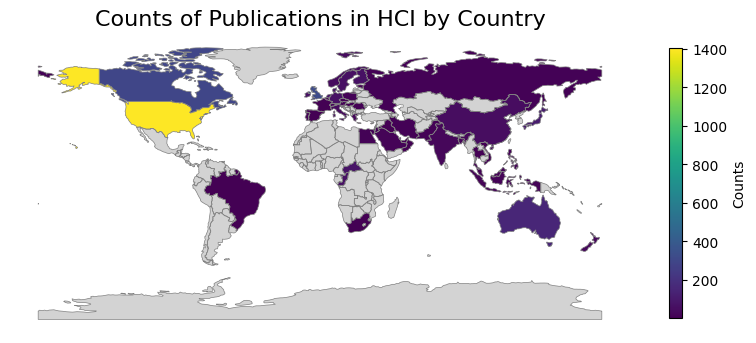

In [ ]:
# Calculate the frequency of appearances for each country in the scholars' dataset
scholars_country = scholars.groupby('Country').size().reset_index(name='Counts')

# Load the world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Map each country name to its corresponding name in the world map dataset
map_country_to_world = {
    row['Country']: process.extractOne(row['Country'], world['name'])[0]
    for index, row in scholars_country.iterrows()
}

# Create a new column 'world_name' in scholars_country DataFrame by mapping country names
scholars_country['world_name'] = scholars_country['Country'].map(map_country_to_world)

# Merge the world map dataset with scholars_country DataFrame based on country names
world = world.merge(scholars_country, how="left", left_on="name", right_on="world_name")

world_counts = scholars_country.groupby('world_name').sum().reset_index()
world_counts.sort_values(by='Counts', ascending=False, inplace=True)

# Plot the world map with counts of publications in HCI by country
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
world.boundary.plot(ax=ax, linewidth=0.5, color='grey')
world.plot(column='Counts', ax=ax, legend=True,
           legend_kwds={'label': "Counts", 'shrink': 0.7, 'aspect': 20},
           cmap='viridis', missing_kwds={'color': 'lightgrey'})
ax.set_axis_off()
plt.title("Counts of Publications in HCI by Country", fontsize=16)

plt.show()

## **4.2 Distribution of Numeric Features**

To understand the distribution of numeric features in our dataset, we generated a set of histograms. Each plot represents a unique feature, providing insights into their distribution and potential skewness.

### **Insights**

- **Total Citations**: The histogram for total citations displays a heavy right skew, with most values concentrated at lower citation counts but a long tail extending to higher values. This indicates that a small number of scholars have extremely high citation counts.

- **Citations in Last 5 Years**: Similar to total citations, this plot shows a right-skewed distribution, indicating that recent citations are also concentrated among a smaller group of scholars.

- **Gender Encode**: The distribution for gender encode is essentially binary, with a roughly even count of values at the extremes (0 and 1), suggesting a balanced gender distribution.

- **Title Encode**: This histogram exhibits a distinct pattern, with most values concentrated at the lower end of the scale, indicating that scholars tend to hold similar titles.

- **Uni Ranking**: The distribution for university ranking is skewed to the right, suggesting a higher frequency of scholars from lower-ranked institutions (numerically higher rankings).

- **CS Ranking**: This plot shows a more dispersed distribution, with various peaks at different ranges. This indicates that scholars are from a diverse range of computer science (CS) ranks.

- **GDP Ranking**: The histogram reveals a right-skewed distribution, indicating that most scholars come from countries with lower GDP rankings (numerically higher).

- **Total Publications**: Like the total citations, this plot has a strong right skew, with the majority of scholars having a relatively low publication count and a smaller number with high counts.

- **Max Citation**: This histogram also exhibits a right-skewed distribution, indicating that while most scholars have modest maximum citation counts, there is a subset with significantly higher maximum citations.

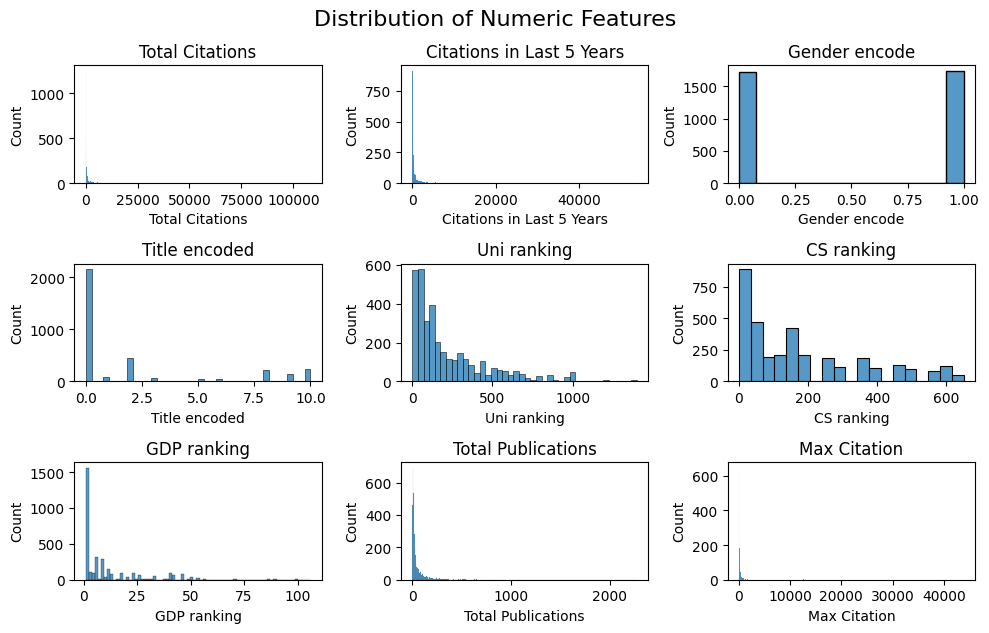

In [ ]:
# Select numeric columns from the scholars' dataset, excluding the 'H-index' and 'I10-index 'column
numeric_columns = scholars.select_dtypes(include=["int", "float"]).columns
numeric_columns = numeric_columns.drop("H-index")
numeric_columns = numeric_columns.drop("I10-index")

# Create a figure for plotting with a specified size
plt.figure(figsize=(10, 8))

# Iterate over each numeric column for plotting
for i, column in enumerate(numeric_columns):
    # Create subplots
    plt.subplot(4, 3, i + 1)
    # Plot the distribution of each numeric feature using histograms
    sns.histplot(data=scholars, x=column)
    # Set title for each subplot
    plt.title(column)

# Set the title for the entire plot
plt.suptitle("Distribution of Numeric Features", fontsize=16)
# Adjust layout to prevent overlapping of subplots
plt.tight_layout()
# Display the plot
plt.show()

## **4.3 Categorical Features vs. H-Index**

With Matplotlib and Seaborn libraries, we construct a composite figure that despicts the variation of the H-index across different categorical features. The figure comprises three box plots, each delving into the nuanced interplay between the H-index and categorical variables such as **gende**`, **academic/professional title**, and **country affiliation**.

### **Insights**

- **Gender Dynamics:** The plot indicates a nearly negligible difference in the median H-index between male and female researchers. This suggests a parity in the recognition and citation of scholarly work across genders, pointing to an equitable academic landscape in terms of research impact.

- **Hierarchical Influence:** A clear pattern emerges when we examine academic titles. The H-index tends to rise with one's career level. 'Professors' have the highest median H-index, suggesting their long-standing contribution to research is well recognized.

- **Global Academic Footprint:** Looking at the H-index by country, the United States stands out with a notably higher median. This reflects a strong network of research and publication. On the other hand, many countries show lower median H-indices, which could be due to a range of reasons like the amount of research funding available or how widely research is shared and cited.

Each of these insights helps us understand how scholarly impact varies and what factors might influence the spread and recognition of research work globally.

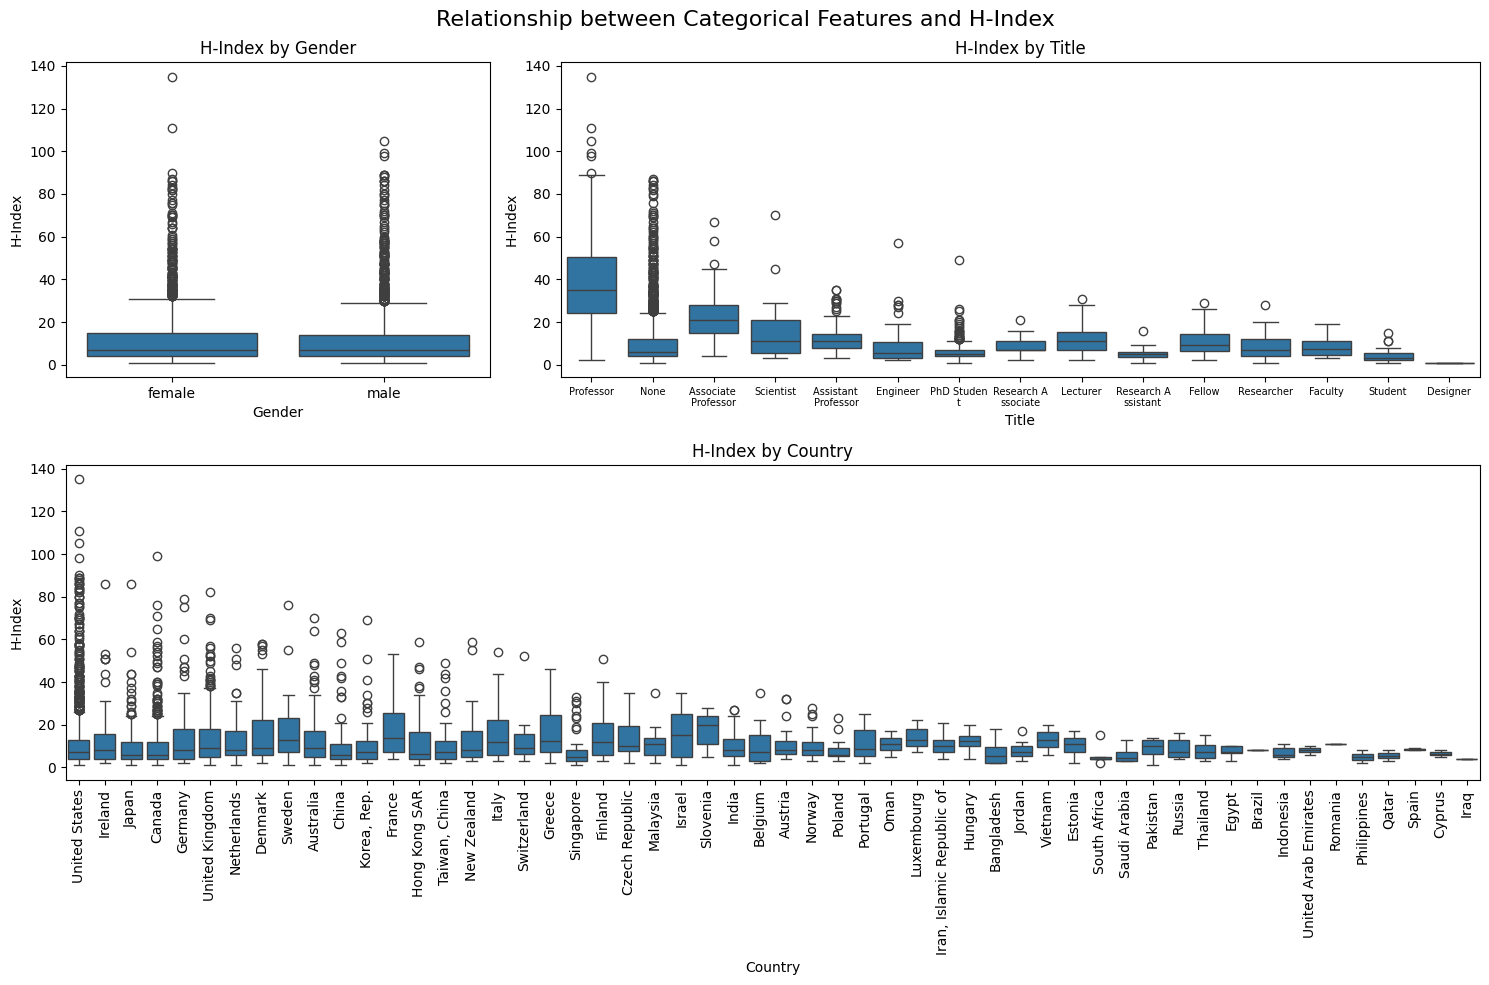

In [ ]:
# Create a figure with subplots for boxplots of H-index by categorical features
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3)

# Subplot for boxplot of H-index by Gender
ax1 = plt.subplot(gs[0, 0])
sns.boxplot(x="Gender", y="H-index", data=scholars)
ax1.set_xlabel("Gender")
ax1.set_ylabel("H-Index")
ax1.set_title("H-Index by Gender")

# Subplot for boxplot of H-index by Title
ax2 = plt.subplot(gs[0, 1:3])
sns.boxplot(x="Title", y="H-index", data=scholars, ax=ax2)
ax2.set_xlabel("Title")
ax2.set_ylabel("H-Index")
ax2.set_title("H-Index by Title")

# Function to automatically wrap long labels to avoid overcrowding
def auto_wrap_labels(labels, max_chars=10):
    wrapped_labels = []
    for label in labels:
        if len(label) > max_chars:
            wrapped_label = '\n'.join([label[i:i+max_chars] for i in range(0, len(label), max_chars)])
            wrapped_labels.append(wrapped_label)
        else:
            wrapped_labels.append(label)
    return wrapped_labels

# Wrap and set x-axis labels for better readability
labels = [item.get_text() for item in ax2.get_xticklabels()]
wrapped_labels = auto_wrap_labels(labels, max_chars=10)
ax2.set_xticklabels(wrapped_labels, fontsize=7)

# Subplot for boxplot of H-index by Country
ax3 = plt.subplot(gs[1, 0:3])
sns.boxplot(x="Country", y="H-index", data=scholars)
ax3.set_xlabel("Country")
ax3.set_ylabel("H-Index")
ax3.set_title("H-Index by Country")
labels = [item.get_text() for item in ax3.get_xticklabels()]
ax3.set_xticklabels(labels, rotation=90)

# Set the main title for the entire plot
plt.suptitle("Relationship between Categorical Features and H-Index", fontsize=16)
plt.tight_layout()
plt.show()

## **4.4 Relationship between Continuous Features and H-Index**

To explore the relationship between continuous scholarly metrics and the H-index, a set of scatter plots was created. These plots illustrate how different continuous variables correlate with the H-index, offering insights into academic impact.

### **Insights**

- **i10-index Correlation:** The scatter plot between the i10-index and the H-index shows a clear positive relationship. As the i10-index (number of publications with at least 10 citations) increases, the H-index tends to rise as well, indicating a direct correlation.

- **Total Citations:** This plot also displays a positive correlation, but with a curvilinear pattern. It suggests that while total citations increase the H-index, the impact diminishes at very high citation counts.

- **Citations in Last 5 Years:** The relationship between citations from the last 5 years and the H-index follows a pattern similar to total citations. Recent scholarly work significantly influences the H-index, but the correlation weakens with higher citation counts.

- **Uni Ranking:** This plot shows a more dispersed relationship between university ranking and H-index. Scholars from lower-ranked institutions (numerically higher rankings) tend to have a wide range of H-index values, indicating a less straightforward correlation.

- **CS Ranking:** The scatter plot for computer science (CS) rankings reveals a spread of H-index values across a range of CS rankings, suggesting that the institutional CS ranking does not always correlate with individual H-index.

- **GDP Ranking:** The relationship between GDP ranking and H-index is varied. Although scholars from higher-ranked (numerically lower) GDP countries tend to have higher H-index values, there's a noticeable spread, indicating other contributing factors.

- **Total Publications:** This scatter plot shows that while there's a positive trend between total publications and the H-index, the distribution is broad, suggesting that the quantity of publications alone doesn't guarantee a high H-index.

- **Max Citation:** The plot between maximum citation and H-index shows a positive correlation, yet with significant variability. It indicates that a high citation count on a single publication can be a strong contributor to a scholar's H-index, but it's not the only factor.

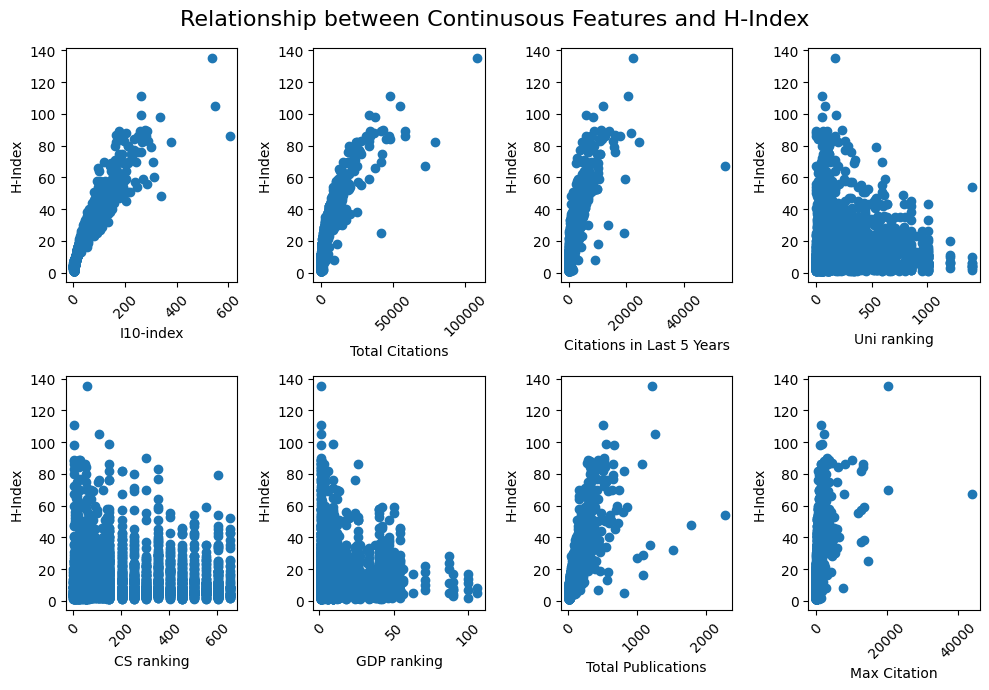

In [ ]:
numeric_columns = scholars.select_dtypes(include=["int", "float"]).columns
numeric_columns = numeric_columns.drop("H-index")
numeric_columns = numeric_columns.drop("Title encoded")
numeric_columns = numeric_columns.drop("Gender encode")

plt.figure(figsize=(10, 7))

for i, column in enumerate(numeric_columns):
  plt.subplot(2, 4, i+1)
  plt.scatter(scholars[column], scholars["H-index"])
  plt.xlabel(column)
  plt.ylabel("H-Index")
  plt.xticks(rotation=45)

plt.suptitle("Relationship between Continusous Features and H-Index", fontsize=16)
plt.tight_layout()
plt.show()

## **4.8 Correlation Heatmap**

A correlation heatmap was created to examine the relationships between various numerical features in the scholarly dataset. The heatmap provides a color-coded visualization of the correlation matrix, offering a quick way to understand how these features are related to each other. Here's a summary of the outcomes:

### **Strong Positive Correlations**
- **H-index and Citation Metrics**: The H-index has strong positive correlations with the i10-index (0.93), total citations (0.83), and citations in the last 5 years (0.78). This indicates that scholars with higher citation metrics generally have a higher H-index, reinforcing the idea that citation-based productivity is closely linked to academic impact.

### **Moderate Correlations**
- **Title Encode and Total Publications**: There's a moderate positive correlation between the encoded academic title and total publication count (0.36). This suggests that individuals with higher academic titles might have more publications, though the correlation isn't particularly high.

- **Max Citation and H-index**: The maximum citation for a scholar's work has a moderate positive correlation with the H-index (0.48). This shows that the most cited work can influence the overall H-index, but other factors also play significant roles.

### **Low or Negligible Correlations**
- **Institutional Rankings**: The heatmap reveals low or negligible correlations between the H-index and institutional rankings (uni ranking -0.02, CS ranking 0.00). This suggests that a high-ranking institution doesn't necessarily mean its scholars will have a high H-index.

- **GDP Ranking and Other Features**: The GDP ranking exhibits minimal correlation with the H-index (0.02), implying that a country's economic standing may not directly affect academic impact.

- **Gender Encode**: The gender encode feature has negligible correlations with other features, indicating that gender does not significantly influence the H-index or other scholarly metrics.

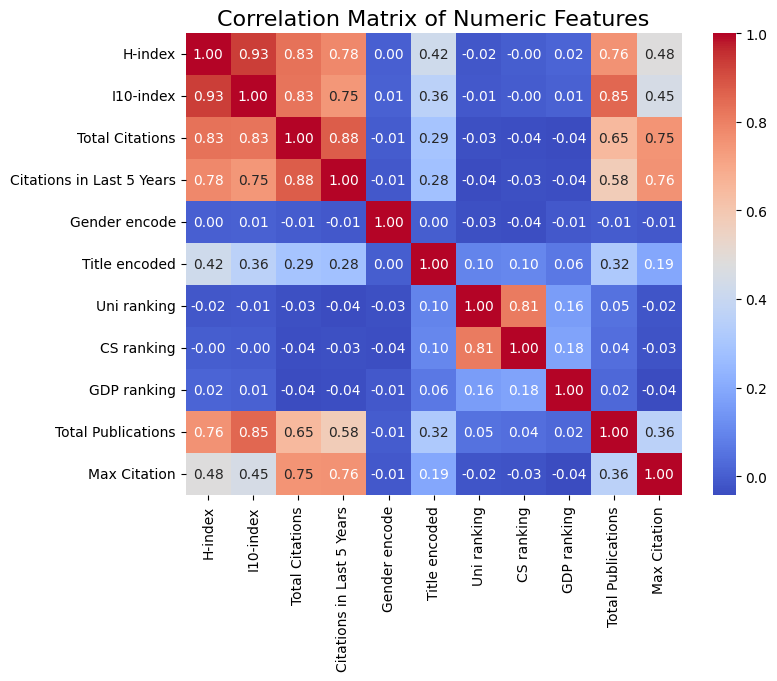

In [ ]:
# Get the numeric columns
numeric_columns = scholars.select_dtypes(include=["int", "float"]).columns

# Create a correlation matrix
correlation_matrix = scholars[numeric_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

# **Part 5: Feature Engineering**

During the feature engineering phase, we focused on three principal tasks to prepare our dataset for subsequent analyses:

1. **Categorical Data Encoding:** We transformed categorical variables into a format suitable for algorithmic processing, facilitating their inclusion in predictive models.

2. **Dataset Partitioning:** The data was divided into training and testing subsets, establishing the groundwork for model validation and performance assessment.

3. **Principal Component Analysis (PCA):** We applied PCA to reduce the dimensionality of our dataset, thereby enhancing computational efficiency and potentially uncovering latent structures in the data.

These steps are essential for refining our dataset into a robust form that supports the rigors of advanced statistical modeling and machine learning.

## **5.1 Categorical Data Encoding**

Categorical data encoding is typically part of feature engineering; however, we integrated it into the data preprocessing phase. This facilitated early-stage visualizations and insights into feature relationships.

Here’s a synopsis of our encoding approach:

1. **Title Encoding**: We instituted a ranking system for academic titles, assigning numerical values according to their standing. 'Professor' is rated highest, whereas titles like 'Student' receive a lower rank, reflecting their academic status.

2. **Institutional Ranking Association**: Utilizing additional QS ranking data, we linked university names with their rankings, providing a gauge for the influence of institutional prestige on academic impact.

3. **Country Encoding**: We used the GDP ranking to encode the country. Encoding countries with GDP ranking is a logical approach, representing economic status, which correlates with research infrastructure and academic resources.

4. **Gender Encoding**: We assigned binary values to gender, simplifying this categorical data for algorithmic interpretation and analysis.

This encoding not only prepared our dataset for machine learning algorithms but also gave us immediate, valuable insights into the structural dynamics of our features.

## **5.2 Dataset Partitioning**

In the realm of model development, we have delineated our `scholars` dataframe into two subsets: **training and testing sets**.

Adherence to the widely accepted **80-20 split ratio** ensures that a majority of the data (80%) is utilized for training, thereby equipping the model with a robust learning base, while 20% is earmarked for testing, providing a credible gauge for the model's performance.

To facilitate consistent and replicable data segmentation, we anchored our process with a **random seed of 42**. This deliberate choice underpins the reproducibility of the split, ensuring that any random elements remain uniform across different executions.

Efficiency in this partitioning process was achieved using the `train_test_split()` function, a staple from the scikit-learn library, known for its reliability and ease of use in machine learning workflows.

**After spliting, the number of training samples is 2762 while the number of testing samples is 691.**

In [ ]:
# Identify non-numeric columns
non_numeric_columns = scholars.select_dtypes(exclude=["int", "float"]).columns

# Drop non-numeric columns from features
scholars = scholars.drop(non_numeric_columns, axis=1)

# Define features and target variable
features = scholars.drop(['H-index', 'I10-index'], axis=1)
target = scholars['H-index']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Print the number of samples in each set
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


Number of training samples: 2762
Number of testing samples: 691


## **5.3 Principal Component Analysis (PCA)**

With our data now split into training and testing data, we also want see whether the application of PCA can help improve the performance of our model.

We need to standardize both datasets before applying PCA. The reason for standardizing is because PCA is not scale-invariant, which means that if we apply PCA without standardizing the data, our results will be drastically different. For this reason, we applied a `StandardScaler()` object to normalize the data before applying PCA.

We then performed PCA on `X_train` and `X_test` to get a new pair of datasets called `X_train_pca` and `X_test_pca`.

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform PCA
pca = PCA()  # retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

### **5.3.1 Optimal Component Selection in PCA**

From this plot, it's clear that the optimal number of components is **around 5**. As we seek to choose the minimum number of components that corresponds to our explained variance threshold, we should choose 5 as it is the intersection point of our 80% explained variance threshold.

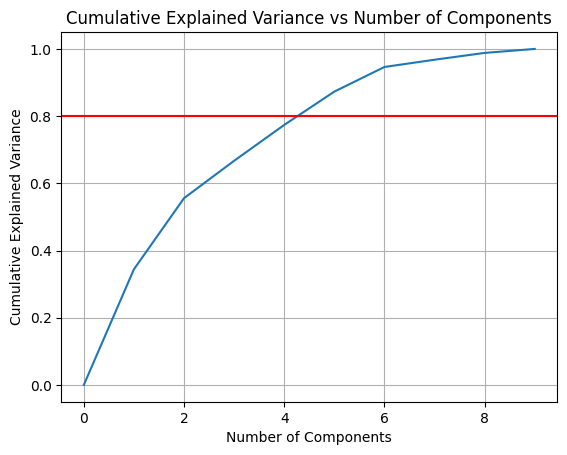

In [ ]:
# Initializing the explained_variance_ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculating the cumulative sum
cum_evr = np.cumsum(explained_variance_ratios)

# Plotting the explained variance vs number of components plot
cum_evr = np.insert(cum_evr, 0, 0) # dummy variable so number of components starts at 1
plt.plot(cum_evr)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.grid()
plt.show()

### **5.3.2 Understanding Researcher Diversity through PCA**

Principal Component Analysis (PCA) is employed to explore the factors that distinguish different researchers within a dataset. By examining the top contributing components of the first three principal components, we gain insights into the key dimensions that set researchers apart.

#### **Top Components of PC1**
The first principal component (PC1) represents the largest source of variance, suggesting key factors that differentiate researchers:

- **Citations in Last 5 Years**: With a coefficient of 0.5347, this feature indicates that recent scholarly activity significantly influences how researchers differ in the primary variance dimension.
- **Total Citations**: The coefficient of 0.5343 for total citations underscores that overall citation counts are a major distinguishing factor.
- **Max Citation**: The coefficient of 0.4671 for max citation indicates that the highest citation count for a single publication contributes notably to researcher differentiation.

These components suggest that the first principal component is mainly driven by citation metrics, emphasizing the role of academic impact in distinguishing researchers.

#### **Top Components of PC2**
The second principal component (PC2) offers a different perspective on researcher differentiation:

- **CS Ranking**: This feature, with a coefficient of 0.6737, indicates that computer science rankings are a critical factor in distinguishing researchers.
- **Uni Ranking**: The coefficient of 0.6714 for university ranking suggests that institutional prestige is another key differentiating factor.
- **GDP Ranking**: A smaller coefficient of 0.2433 indicates that a country's economic standing plays a role in researcher differentiation, though to a lesser extent.

The features contributing to PC2 suggest that this component is influenced by institutional background and economic rankings, indicating how institutional context differentiates researchers.

#### **Top Components of PC3**
The third principal component (PC3) sheds light on other factors contributing to researcher diversity:

- **Gender Encode**: With a coefficient of -0.9897, this feature indicates that gender has a significant negative influence, suggesting that gender-based differences are a key factor in this component.
- **Title Encoded**: A positive coefficient of 0.1008 suggests that academic titles play a smaller but noticeable role in differentiating researchers.
- **GDP Ranking**: The coefficient of -0.0895 suggests that GDP ranking has a minor negative influence in this context.

These components suggest that PC3 is driven by gender-based distinctions, with some influence from academic titles and institutional economic standings. This points to gender and institutional factors as key differentiators among researchers.

In summary, PCA helps identify the key components that contribute to researcher diversity. PC1 emphasizes citation-based metrics, PC2 focuses on institutional rankings, and PC3 is influenced by gender encoding. These results highlight the various dimensions through which researchers can differ, providing a deeper understanding of the underlying factors that create this diversity.

In [ ]:
# Perform PCA with component number of 5
pca = PCA(n_components = 5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Extract the top three components for the first three principal components
top_components = pca.components_[:3]  # Get the first three PCs

# Identify the indices of the top three absolute values in each of the first three PCs
top_indices = np.argsort(np.abs(top_components), axis=1)[:, -3:]

# Now, print the top three components for each of the first three principal components
for i in range(3):
    print(f"Top 3 components of PC{i+1}:")
    for index in top_indices[i, :][::-1]:  # Reverse to show highest first
        column_name = features.columns[index]
        print(column_name, f": {top_components[i, index]}")
    print()

Top 3 components of PC1:
Citations in Last 5 Years : 0.5348779187491876
Total Citations : 0.534625817849072
Max Citation : 0.4672877679891721

Top 3 components of PC2:
CS ranking : 0.6733092028376748
Uni ranking : 0.6710836931141247
GDP ranking : 0.24325445509804944

Top 3 components of PC3:
Gender encode : -0.987675749686706
Title encoded : -0.13316482251484207
Max Citation : 0.05254990791274801



# **Part 6: Modeling**



## **6.1 Linear Regression**

To predict the H-Index, we used the Linear Regression Model as our baseline model. Moreover, in order to test whether PCA would help with the prediction or not, we applied the model on 2 set of data:

1. `X_train_scaled` and `X_test_scaled`
2. `X_train_pca` and `X_test_pca`

### **Code Pipeline:**

- **Model Initialization & Training:** We instantiate the LinearRegression model and fit it to the scaled training data, facilitating the discovery of underlying patterns that map the features to the target variable.

- **R^2 Value Computation:**  We calculate the coefficient of determination, commonly known as the $R^2$ value, for both the training and testing sets. This statistic measures the proportion of variance in the dependent variable that is predictable from the independent variables.

- **Prediction & Error Quantification:** The model then makes predictions on the scaled testing data. To evaluate the accuracy of these predictions, we compute the Mean Squared Error (MSE), which provides a measure of the average squared difference between the observed actual outcomes and the outcomes predicted by the model.

### **6.1.1 Linear Regression with PCA**

In [ ]:
reg = LinearRegression()
reg.fit(X_train_pca, y_train)

# R^2 value calculation
score_train = reg.score(X_train_pca, y_train)
score_test = reg.score(X_test_pca, y_test)

# Predict on transformed test data using the linear regression model
y_pred = reg.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print('Training Set R^2 value: ' + str(score_train))
print('Testing Set R^2 value: ' + str(score_test))
print('Testing Mean Squared Error: ' + str(mse))

Training Set R^2 value: 0.7173559484247376
Testing Set R^2 value: 0.7874261373861968
Testing Mean Squared Error: 46.193633582163415


### **6.1.2 Linear Regression with Standardization**

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

# R^2 value calculation
score_train = linear_reg.score(X_train_scaled, y_train)
score_test = linear_reg.score(X_test_scaled, y_test)

# Predict on transformed test data using the linear regression model
y_pred = linear_reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print('Training Set R^2 value: ' + str(score_train))
print('Testing Set R^2 value: ' + str(score_test))
print('Testing Mean Squared Error: ' + str(mse))

Training Set R^2 value: 0.8398149174833051
Testing Set R^2 value: 0.8273276972827179
Testing Mean Squared Error: 37.52277435914925


### **6.1.3 Linear Regression Model Assessment**

Upon examining the $R^2$ scores and Mean Squared Error (***MSE***) for the linear regression models with and without the application of PCA, we discern that incorporating PCA does not enhance prediction performance. This suggests that the initial feature set may have been relatively noise-free, and the dimensionality reduction through PCA inadvertently omitted valuable information critical for precise prediction.

#### **Coefficient Analysis**

In our coefficient analysis, we delve into the factors influencing scholarly impact, particularly measured by the H-index. Let's unpack these findings:

- **Total Citations:** This feature stands out with a robust coefficient of 8.0697, indicating a significant positive impact on the H-index. It underscores the pivotal role of overall citation volume in determining academic noteworthiness.

- **Citations in Last 5 Years:** Following closely, we observe a coefficient of 5.3121, emphasizing the importance of recent citations in shaping a researcher's current impact. This reaffirms the influence of recent work on scholarly recognition.

- **Max Citation:** Interestingly, Max Citation exhibits a notable negative coefficient of -5.2126, suggesting a nuanced relationship where an exceptionally cited work doesn't necessarily translate to a higher H-index. This highlights the complexity of academic impact assessment.

- **Total Publications:** With a positive coefficient of 3.2360, Total Publications emerges as a significant contributor to the H-index. This suggests that the quantity of published work positively influences scholarly recognition, supporting the notion of prolific publishing as beneficial.

- **Title encoded:** The coefficient of 1.9859 for title_encoded indicates a positive correlation between academic titles and scholarly impact. This aligns with the expectation that higher academic positions often coincide with greater recognition in academia.

- **Uni ranking, CS ranking, GDP ranking:** These variables exhibit coefficients of varying magnitudes, indicating their respective influences on the H-index. While Uni ranking shows a negative coefficient of -0.7871, suggesting a potential impact on scholarly recognition, CS ranking and GDP ranking present positive coefficients, albeit of smaller magnitude, indicating their minor influences on academic impact.

- **Gender encode:** Lastly, with a minimal coefficient of 0.1064, gender_encode suggests a slight influence on the H-index, indicating a broader, more inclusive evaluation framework that transcends gender-related factors.

In conclusion, our coefficient analysis sheds light on the multifaceted determinants of scholarly impact, emphasizing the interplay between citation metrics, publication records, academic titles, and institutional rankings. These insights contribute to a nuanced understanding of academic productivity and recognition, challenging simplistic narratives and highlighting the diverse factors shaping scholarly impact.

In [ ]:
# Extracting coefficients
coefficients = linear_reg.coef_

# Create a dataframe for easier viewing
features = X_train.columns  # Ensure 'X' is your feature dataframe
feature_importance = pd.DataFrame(coefficients, index=features, columns=['Coefficient'])

# Sorting the features by the absolute value of their coefficient for better visibility
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
sorted_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display
print(sorted_features)

                           Coefficient  Abs_Coefficient
Total Citations               8.054834         8.054834
Citations in Last 5 Years     5.326986         5.326986
Max Citation                 -5.211430         5.211430
Total Publications            3.232211         3.232211
Title encoded                 1.983042         1.983042
Uni ranking                  -0.775417         0.775417
CS ranking                    0.551613         0.551613
GDP ranking                   0.380600         0.380600
Gender encode                 0.154527         0.154527


## **6.2 Random Forest Regression**

We utilized the Random Forest Regression model to predict the target variable, aiming to capture complex relationships between features and outcomes. The model was evaluated across two sets of scaled data for training and testing purposes.

### **Code Pipeline:**

- **Model Initialization & Training:** We instantiated the `RandomForestRegressor` model with 100 estimators and a fixed random seed for reproducibility. The model was then fitted to the scaled training data (`X_train_scaled` and `y_train`), enabling it to learn the intricate patterns and correlations required for accurate prediction.

- **R^2 Value Computation:** To assess the model's performance, we calculated the $R^2$ values for both training and testing sets. This metric quantifies the proportion of the target variable's variance explained by the model. The training set's $R^2$ score was `score_train`, while the testing set's score was `score_test`.

- **Prediction & Error Quantification:** The model generated predictions on the scaled testing data. We measured prediction accuracy using the Mean Squared Error (MSE) to capture the average squared difference between observed actual outcomes and model predictions. The testing set MSE was `mse`.



In [ ]:
# Creating a Random Forest Regressor model
reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Training the model
reg.fit(X_train_scaled, y_train)

# R^2 value calculation
score_train = reg.score(X_train_scaled, y_train)
score_test = reg.score(X_test_scaled, y_test)

# Predict on transformed test data using the linear regression model
y_pred = reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Evaluating the model's performance
print('Training Set R^2 value: ' + str(score_train))
print('Testing Set R^2 value: ' + str(score_test))
print('Testing Mean Squared Error: ' + str(mse))

Training Set R^2 value: 0.9963701207795721
Testing Set R^2 value: 0.9642872190429078
Testing Mean Squared Error: 7.760611287988424


### **6.2.1 Random Forest Regression with Grid Search Hyperparameter Tuning**

We initialized a base `RandomForestRegressor` model and conducted grid search across 216 parameter combinations, leading to a total of 648 fits. After evaluating each configuration using 3-fold cross-validation, the grid search identified the optimal hyperparameters:

- **Best Hyperparameters**:
  - `bootstrap`: True
  - `max_depth`: 10
  - `min_samples_leaf`: 1
  - `min_samples_split`: 2
  - `n_estimators`: 100

These hyperparameters control the depth and structure of the trees, the conditions required for splitting nodes, and the number of decision trees in the ensemble, allowing the model to effectively capture and generalize patterns.

#### **Performance Analysis:**

- **Training Set R^2 Value**: 0.9950  
  The model explains 99.5% of the variance in the training set. This high $R^2$ value demonstrates the model's ability to learn the complex relationships between the features and the target variable, suggesting good fit during training.

- **Testing Set R^2 Value**: 0.9640  
  The model retains a strong predictive performance on unseen data, explaining 96.4% of the variance in the testing set. This result shows that the model generalizes well, as the testing $R^2$ value is relatively close to the training value.

- **Testing Mean Squared Error (MSE)**: 7.8255  
  The MSE quantifies the average squared difference between predicted and actual values on the testing set. An MSE of 7.8255 indicates that the model is fairly accurate, with relatively low error in predicting the target variable.

Overall, the grid search results demonstrate that the optimized Random Forest model is capable of providing accurate and consistent predictions, effectively balancing between underfitting and overfitting by using the specified hyperparameters.

#### Analysis of Feature Importance in the Random Forest

The analysis of feature importances from the RandomForestRegressor model reveals the following insights:

1. **Total Citations (0.9374)**: This feature has the highest importance, significantly influencing the model's predictions. It suggests that the overall citation count of a researcher is the most critical factor in predicting their H-index, indicating the cumulative impact of their work.

2. **Total Publications (0.0365)**: Although much less influential than Total Citations, the quantity of published work still plays a role, supporting the idea that a larger body of work can positively affect academic recognition.

3. **Max Citation (0.0148)**: The highest citation count for a single work has a minor influence compared to total citations, implying that standout publications have less impact on the overall academic stature than the total body of work.

4. **University Ranking (0.0042)**: The ranking of the institution has a very small effect, suggesting that the academic environment contributes slightly to the H-index but is not a primary factor.

5. **Citations in Last 5 Years (0.0036)**: Recent work's impact is minor, which contrasts with the common belief that recent citations are crucial. This could indicate that the long-term citation history is more critical for the H-index.

6. **CS Ranking (0.0017)**: The ranking in the field of Computer Science has a minimal influence, suggesting that specific departmental prestige is less relevant than broader factors.

7. **GDP Ranking (0.0010)**: The economic strength of the country is among the least impactful factors, indicating that macroeconomic conditions do not significantly influence individual academic performance.

8. **Title Encoded (0.0006)**: The academic title holds a very minimal effect, suggesting that formal titles do not heavily influence the H-index when other factors are considered.

9. **Gender Encode (0.0003)**: Gender has the least impact, reinforcing the notion that academic merit and output, rather than gender, are the primary drivers of scholarly recognition.

This detailed breakdown highlights the dominance of citation metrics, especially the total number of citations, in predicting academic success, while other factors like institutional prestige, economic conditions, and personal titles play significantly lesser roles.

In [ ]:
# Creating a base RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

# Defining the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Conducting the grid search
grid_search.fit(X_train_scaled, y_train)

# Displaying the best hyperparameters found
print(f'Best hyperparameters: {grid_search.best_params_}')

# Using the best model to make predictions
best_RF_model = grid_search.best_estimator_
y_pred = best_RF_model.predict(X_test_scaled)

# Evaluating the model's performance
score_train = best_RF_model.score(X_train_scaled, y_train)
score_test = best_RF_model.score(X_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred)

# Fetching the feature importances from the best model
importances = best_RF_model.feature_importances_
# Associating feature importances with their corresponding feature names
feature_names = X_train.columns
# Creating a sorted list of features based on their importance
sorted_feature_importances = sorted(zip(importances, feature_names), reverse=True)

print('Training Set R^2 value: ' + str(score_train))
print('Testing Set R^2 value: ' + str(score_test))
print('Testing Mean Squared Error: ' + str(mse))

# Printing the feature names along with their importances
for importance, name in sorted_feature_importances:
    print(f"{name}: {importance}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training Set R^2 value: 0.9950218560721208
Testing Set R^2 value: 0.9639887185946632
Testing Mean Squared Error: 7.825477307548772
Total Citations: 0.9373512683581724
Total Publications: 0.03646151548908403
Max Citation: 0.014849440352717378
Uni ranking: 0.004206132711944034
Citations in Last 5 Years: 0.003607648541785897
CS ranking: 0.0016619358222265126
GDP ranking: 0.0010015097085528267
Title encoded: 0.0005904275153365945
Gender encode: 0.00027012150018046856


## **6.3 AdaBoost Regression**

In this implementation, we used the AdaBoost Regressor model to predict the target variable and measure its performance on scaled datasets. The model was trained and evaluated across standardized training and testing datasets to determine its ability to generalize.

- **Model Initialization & Training:** We initialized the `AdaBoostRegressor` model with 100 estimators and a learning rate of 0.1. The model was trained on the scaled training data (`X_train_scaled` and `y_train`) to learn patterns that accurately map the features to the target variable.

- **R^2 Value Calculation:** We computed the coefficient of determination ($R^2$) for both the training and testing sets to quantify the proportion of variance explained by the model. On the training set, the $R^2$ value was `score_train`, while on the testing set, the $R^2$ value was `score_test`.

- **Prediction & Error Quantification:** Using the trained model, predictions were generated for the scaled testing data (`X_test_scaled`). The Mean Squared Error (MSE) was computed to quantify the average squared difference between observed actual outcomes and predicted values. The testing set's MSE was `mse`.

This analysis helps verify the model's accuracy and identify potential areas for improvement in terms of feature selection, hyperparameter tuning, or alternative model architectures.

In [ ]:
# Creating a adaboost model
reg = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Training the model
reg.fit(X_train_scaled, y_train)

# R^2 value calculation
score_train = reg.score(X_train_scaled, y_train)
score_test = reg.score(X_test_scaled, y_test)

# Predict on transformed test data using the linear regression model
y_pred = reg.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Evaluating the model's performance
print('Training Set R^2 value: ' + str(score_train))
print('Testing Set R^2 value: ' + str(score_test))
print('Testing Mean Squared Error: ' + str(mse))

Training Set R^2 value: 0.9647665882188445
Testing Set R^2 value: 0.942214345405547
Testing Mean Squared Error: 12.557185167638245


### **6.3.1 AdaBoost Regression with Grid Search Hyperparameter Tuning**

We leveraged the AdaBoost Regressor model for predictive modeling and optimized it through grid search to identify the most effective hyperparameters.

- **Model Initialization & Grid Setup:** We initialized an `AdaBoostRegressor` model with a fixed random seed (`random_state=42`) and created a grid of hyperparameters, including the number of estimators (`n_estimators`), learning rate (`learning_rate`), and loss function type (`loss`), to evaluate different parameter combinations.

- **Grid Search Execution:** Using `GridSearchCV`, we conducted a 3-fold cross-validation grid search to explore 36 different parameter combinations. The search evaluated each model based on negative mean squared error (MSE) to identify the optimal hyperparameters.

- **Optimal Hyperparameters Identification:** The best hyperparameters were:
  - `learning_rate`: 0.1
  - `loss`: exponential
  - `n_estimators`: 200

  These parameters were then used to build the best estimator, `best_model`.

- **Prediction & Evaluation:** With the best model, predictions were made on the scaled testing data (`X_test_scaled`). The model's $R^2$ values were calculated for both training and testing sets to measure its ability to explain the target variable variance. The training set achieved an $R^2$ value of 0.9664, and the testing set scored 0.9415, indicating strong generalization capabilities. The Mean Squared Error (MSE) for the testing set was 12.7068.

These results illustrate that the optimized AdaBoost model is effective in capturing data patterns and generalizing its learned patterns to new, unseen data.

#### Analysis of Feature Importance in the Optimized AdaBoost Model

The AdaBoost Regressor model's ability to assess the relative importance of features provides valuable insights into which factors most strongly influence the predictive performance regarding the target variable. Here’s a detailed analysis of the feature importances obtained from the model:

1. **Total Citations (0.7691)**: This feature dominates the importance scores, highlighting its critical role in predicting the target variable. The high importance suggests that the cumulative impact of a researcher's citations across their career is the strongest predictor of their academic success, as measured in this model.

2. **Total Publications (0.1547)**: Significantly influential but less so than Total Citations, this feature indicates that the volume of work published by a researcher also plays a substantial role. It supports the notion that both the quality (as reflected by citations) and quantity of research outputs are key to academic achievement.

3. **Max Citation (0.0460)**: The highest citation count of a single work contributes modestly, implying that while standout works are important, they do not carry as much weight as the overall citation record.

4. **Citations in Last 5 Years (0.0233)**: Recent citations have a smaller impact compared to total citations, suggesting that long-term citation impact outweighs more recent activities in this model’s estimation of academic influence.

5. **University Ranking (0.0040)**: The ranking of the institution with which a researcher is affiliated shows minimal influence on the model's predictions, indicating that personal academic outputs are more decisive than the prestige of the institution.

6. **CS Ranking (0.0028)**: Similarly, the ranking within the specific field of Computer Science has a very minor effect, reinforcing the idea that individual performance is more significant than departmental or institutional standing.

7. **Title Encoded (0.00006)** and **Gender Encode (0.0)**: Both these features exhibit negligible to no influence. The academic title and gender of a researcher do not affect the predictions significantly, suggesting that the model views academic merit as largely independent of these factors.

8. **GDP Ranking (0.0)**: The economic strength of the country is shown to have no impact, indicating that the model does not associate national economic conditions with individual academic performance.

This feature importance analysis underscores the critical importance of a researcher's citation history in determining their academic impact, with lesser but still notable roles for publication volume and the impact of standout publications. It also highlights the relative unimportance of institutional prestige, specific academic titles, and gender in influencing academic success as modeled here.

In [ ]:
# Defining the AdaBoost model
model = AdaBoostRegressor(random_state=42)

# Defining the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential']
}

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Conducting the grid search
grid_search.fit(X_train_scaled, y_train)

# Displaying the best hyperparameters found
print(f'Best hyperparameters: {grid_search.best_params_}')

# Using the best model to make predictions
best_ada_model = grid_search.best_estimator_
y_pred = best_ada_model.predict(X_test_scaled)

# Evaluating the model's performance
score_train = best_ada_model.score(X_train_scaled, y_train)
score_test = best_ada_model.score(X_test_scaled, y_test)
mse = mean_squared_error(y_test, y_pred)

# Fetching the feature importances from the best model
importances = best_ada_model.feature_importances_
# Associating feature importances with their corresponding feature names
feature_names = X_train.columns
# Creating a sorted list of features based on their importance
sorted_feature_importances = sorted(zip(importances, feature_names), reverse=True)

print('Training Set R^2 value: ' + str(score_train))
print('Testing Set R^2 value: ' + str(score_test))
print('Testing Mean Squared Error: ' + str(mse))

# Printing the feature names along with their importances
for importance, name in sorted_feature_importances:
    print(f"{name}: {importance}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best hyperparameters: {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 200}
Training Set R^2 value: 0.9663570543466731
Testing Set R^2 value: 0.9415258093266589
Testing Mean Squared Error: 12.706808375991201
Total Citations: 0.7691276334545611
Total Publications: 0.15469629906441096
Max Citation: 0.04596640769724549
Citations in Last 5 Years: 0.02331384567839901
Uni ranking: 0.004006242487098391
CS ranking: 0.0028258942521161186
Title encoded: 6.36773661696417e-05
Gender encode: 0.0
GDP ranking: 0.0


## **6.4 Feedforward Neural Network (FNN)**

To estimate the predictive power of a feedforward neural network (FNN), we designed an architecture that incorporates both batch normalization and dropout layers. This structure was implemented with a focus on enhancing the model's ability to generalize and mitigate overfitting.

- **Data Preparation:**  
  First, we determined the appropriate device (`cpu` or `cuda`) based on the availability of GPU resources. The training and testing data were then converted to PyTorch tensors of type `torch.float32` and moved to the selected device.

- **Model Definition:**  
  The `ImprovedFNN` class encapsulates the neural network's architecture:
  - **Input Layer:** The network accepts input features through a fully connected (`fc1`) layer with 128 neurons.
  - **Hidden Layers:** Three hidden layers are designed with progressively fewer neurons:
    - `fc1` (128 neurons), `fc2` (64 neurons), and `fc3` (32 neurons)
  - **Batch Normalization:** Each hidden layer is followed by a batch normalization layer (`bn1`, `bn2`, `bn3`) to stabilize training.
  - **Dropout:** After batch normalization, a dropout layer (`dropout` with a rate of 0.3) is applied to randomly deactivate a portion of the neurons to improve generalization.
  - **Output Layer:** The final fully connected layer (`fc4`) generates the model's predictions.

- **Forward Propagation:**  
  In the `forward` method, the input is passed through each layer sequentially. Non-linear transformations are applied using the `ReLU` activation function after the batch normalization layers. Finally, the output is generated through the last fully connected layer.

By combining batch normalization, dropout, and non-linear activation functions, this network architecture aims to balance model complexity with generalization. The ultimate goal is to provide robust predictive capabilities across various data distributions.

In [ ]:
# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_train_array = np.array(y_train)
y_test_array = np.array(y_test)

# Converting data to PyTorch tensors and sending them to the appropriate device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32).unsqueeze(1).to(device)

# Defining a more complex FNN model with Dropout and Batch Normalization
class ImprovedFNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

### **6.4.1 Training and Validation Process**

We trained the `ImprovedFNN` model over 2000 epochs to accurately predict the target variable, while tracking training and validation loss values throughout the process.

- **Model Setup:**  
  The model was initialized with an input layer based on the number of features, and batch normalization and dropout layers were integrated to improve stability and generalization. The loss function used was Mean Squared Error (MSE), and the Adam optimizer was set with a learning rate of 0.001.

- **Training Process:**  
  During each epoch, the following steps were executed:
  1. **Training Step:**  
     - The model was put in training mode to learn from the training dataset (`X_train_tensor`, `y_train_tensor`).
     - The model's gradients were zeroed out before each update using `optimizer.zero_grad()`.
     - Predictions were generated using the training data, and the MSE loss was calculated based on the differences between predictions and actual targets.
     - The optimizer updated the model parameters based on the backpropagated loss.

  2. **Validation Step:**  
     - The model was put in evaluation mode to generate predictions on the testing dataset (`X_test_tensor`, `y_test_tensor`) without calculating gradients.
     - The validation loss was computed by comparing predicted values to the actual test targets.

  3. **Loss Tracking:**  
     - Both training and validation losses were recorded in separate lists for each epoch.
     - Every 200 epochs, the training and validation losses were printed to monitor progress.

- **Training Results:**  
  Over the 2000 epochs:
  - **Training Loss Reduction:** The training loss decreased significantly, starting at 150.5972 and dropping to 4.4419, indicating the model successfully learned to predict the target values from the training data.
  - **Validation Loss Reduction:** The validation loss also showed substantial initial improvement, decreasing from 170.3736 to a minimum of 5.6290 at epoch 1200 before stabilizing at around 6.8647 at epoch 2000.
  
These results suggest that the model learned effectively, with the validation loss reaching a consistent range indicative of generalization. However, a slight increase in validation loss towards the end suggests potential overfitting, indicating that early stopping or further regularization could be beneficial in subsequent training.

In [ ]:
# Initializing the model, loss function, and optimizer
model = ImprovedFNN(input_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 2000

# Arrays to store the training and validation losses per epoch
train_losses = []
val_losses = []

# Training loop without early stopping
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Evaluate the validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)

    # Store the training and validation losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    # Print the training and validation losses every 10 epochs
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

Epoch [200/2000], Training Loss: 141.1536, Validation Loss: 160.7193
Epoch [400/2000], Training Loss: 23.2685, Validation Loss: 24.5002
Epoch [600/2000], Training Loss: 7.7247, Validation Loss: 8.8964
Epoch [800/2000], Training Loss: 6.4023, Validation Loss: 6.9947
Epoch [1000/2000], Training Loss: 5.5840, Validation Loss: 6.6461
Epoch [1200/2000], Training Loss: 5.0549, Validation Loss: 5.9094
Epoch [1400/2000], Training Loss: 5.1270, Validation Loss: 7.2427
Epoch [1600/2000], Training Loss: 4.9467, Validation Loss: 6.6991
Epoch [1800/2000], Training Loss: 4.2476, Validation Loss: 7.6522
Epoch [2000/2000], Training Loss: 4.1110, Validation Loss: 8.8593


### **6.4.2 Training and Validation Loss Curves Analysis**

The plot visualizes the loss curves over 2000 epochs for both the training and validation datasets. The lines represent the Mean Squared Error (MSE) as a function of training epochs, revealing trends in model convergence and generalization.

**Observations**:

1. **Initial Decrease**:
   - During the initial epochs, there is a rapid decline in both training (blue) and validation (orange) loss curves, indicating effective learning as the model quickly captures essential patterns in the data.

2. **Convergence**:
   - After around 300 epochs, the loss curves begin to stabilize, suggesting that the model has learned most patterns in the data.
   - Both training and validation losses plateau at a low level, showing that the model has mostly converged.

3. **Overfitting Signs**:
   - After approximately 1000 epochs, the validation loss begins to increase while the training loss continues to decrease. This divergence between training and validation losses is a sign of overfitting, indicating that the model starts to memorize training data rather than generalizing well to unseen data.

**Testing Performance**:

- **Testing R^2**: The model achieved a testing $R^2$ value of 0.9684, which means it can explain 96.84% of the variance in the testing data. This high score demonstrates that the model effectively captures the underlying relationships in the features.
  
- **Testing Mean Squared Error**: The testing Mean Squared Error (MSE) was 6.8647, reflecting the average squared difference between predicted and actual values. This low MSE value indicates accurate predictions on the test data.

Overall, the loss curves and evaluation metrics reflect that the model learned patterns well, achieved good performance in explaining testing data variance, but is susceptible to overfitting when trained for too many epochs.

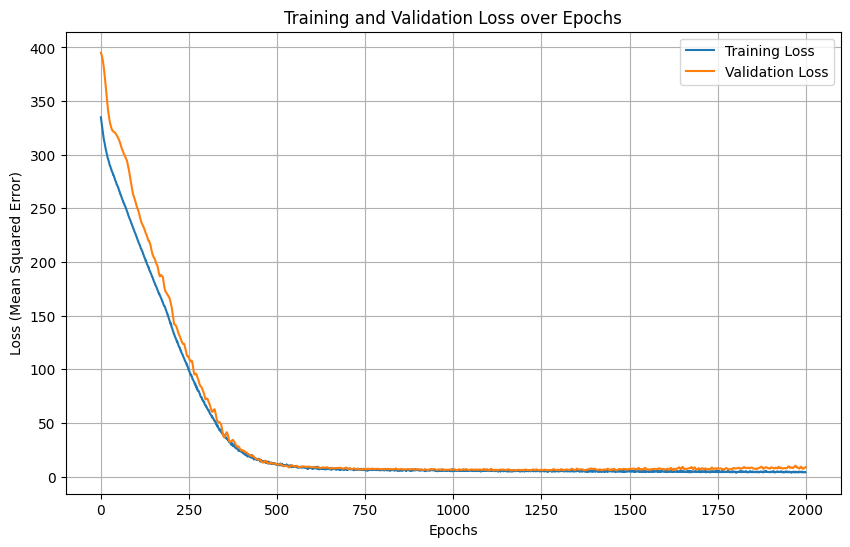

Testing R^2: 0.9592
Testing Mean Squared Error: 8.8593


In [ ]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Evaluating the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# Calculating Mean Squared Error on the test set
test_r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Testing R^2: {test_r2:.4f}")
print(f"Testing Mean Squared Error: {mse:.4f}")

### **6.4.3 Results of Hyperparameter Tuning for TunedFNN**

The systematic approach to tuning the `TunedFNN` neural network using `GridSearchCV` has yielded a set of optimal hyperparameters that enhance the model's performance. Here’s a detailed overview of the results and their implications:

- **Best Hyperparameters**:
  - **Batch Size**: The optimal batch size was identified as 128. This size strikes a balance between computational efficiency and the ability to generalize, reducing the risk of overfitting compared to smaller batch sizes.
  - **Learning Rate (`lr`)**: A learning rate of 0.001 proved most effective, allowing the model to converge steadily without overshooting the minimum loss.
  - **Hidden Dimensions**:
    - **`module__hidden_dim1`: 256** - This first layer size provides a broad capacity to learn complex patterns from the input data.
    - **`module__hidden_dim2`: 128** - The second layer continues to refine the features extracted by the first, maintaining substantial complexity.
    - **`module__hidden_dim3`: 16** - The addition of a third, smaller hidden layer helps in further processing the features with a focus on essential characteristics, which is crucial for performance without overfitting.
  - **Dropout Rate (`module__dropout_rate`)**: A rate of 0.2 is optimal, offering effective regularization that helps prevent overfitting while still allowing the network to learn significant patterns.
  - **Optimizer**: The use of Adam optimizer with a weight decay of 0.001 enhances the learning process by adjusting the weights more finely, which helps in avoiding local minima and ensures a better generalization on unseen data.

#### **Implications of Tuning Results:**

These results illustrate a well-balanced approach to model configuration, where each parameter is set to optimize learning dynamics and model robustness. The chosen batch size and learning rate ensure that the model trains efficiently and effectively, while the configuration of hidden layers and dropout manages the complexity of the model, allowing it to learn detailed patterns without memorizing the training data.

This optimal setting empowers the `TunedFNN` to perform at its best, effectively capturing and generalizing patterns from the data. As a result, the model is expected to deliver high accuracy and reliability in predictions, making it well-suited for tasks requiring nuanced understanding and prediction of data behaviors.

In [ ]:
# class TunedFNN(nn.Module):
#     def __init__(self, input_dim=10, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
#         super(TunedFNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.bn1 = nn.BatchNorm1d(hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.bn2 = nn.BatchNorm1d(hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
#         self.bn3 = nn.BatchNorm1d(hidden_dim3)
#         self.fc4 = nn.Linear(hidden_dim3, 1)
#         self.dropout = nn.Dropout(p=dropout_rate)

#     def forward(self, x):
#         x = torch.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = torch.relu(self.bn2(self.fc2(x)))
#         x = self.dropout(x)
#         x = torch.relu(self.bn3(self.fc3(x)))
#         x = self.dropout(x)
#         x = self.fc4(x)
#         return x

# # Callback to monitor the best validation R^2 score
# best_r2 = EpochScoring('r2', lower_is_better=False, name='val_r2')

# # Wrapping the PyTorch model with skorch's NeuralNetRegressor
# net = NeuralNetRegressor(
#     TunedFNN,
#     module__input_dim=X_train.shape[1],  # Number of input features
#     max_epochs=50,
#     lr=0.001,
#     optimizer=optim.Adam,
#     criterion=nn.MSELoss,
#     batch_size=32,
#     train_split=None,  # We'll handle validation splitting separately
#     callbacks=[best_r2]
# )

# # Defining the grid of hyperparameters to search
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'batch_size': [16, 32, 64],
#     'module__hidden_dim1': [64, 128, 256],
#     'module__hidden_dim2': [32, 64, 128],
#     'module__hidden_dim3': [16, 32, 64],
#     'module__dropout_rate': [0.2, 0.3, 0.5]
# }

# # Using GridSearchCV for hyperparameter tuning
# scorer = make_scorer(mean_squared_error, greater_is_better=False)
# grid_search = GridSearchCV(estimator=net, param_grid=param_grid, scoring=scorer, refit=True, cv=3, verbose=-1)

# # Conducting the grid search
# grid_search.fit(X_train_tensor, y_train_tensor)

# # Displaying the best hyperparameters found
# print(f'Best hyperparameters: {grid_search.best_params_}')


### 6.4.4 **Enhanced FNN Model Deployment and Performance Evaluation**

With the best hyperparameters deriving from previous tuning process, the final FNN results in a $R^2$ of 0.9651 and a $MSE$ of 7.5772 for the testing set, which is also the best predictive model in this research.

In [ ]:
class TunedFNN(nn.Module):
    def __init__(self, input_dim=10, hidden_dim1=128, hidden_dim2=64, hidden_dim3=32, dropout_rate=0.3):
        super(TunedFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Extract best parameters obtained from the grid search
best_params = {
    'batch_size': 128,
    'lr': 0.001,
    'module__dropout_rate': 0.2,
    'module__hidden_dim1': 256,
    'module__hidden_dim2': 128,
    'module__hidden_dim3': 16,
    'optimizer': optim.Adam,
    'optimizer__weight_decay': 0.001
}


# Set up early stopping
early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=30,
    threshold=0.001,
    lower_is_better=True
)

# Configure the final model using the best parameters
final_net = NeuralNetRegressor(
    TunedFNN,
    module__input_dim=X_train.shape[1],
    module__hidden_dim1=best_params['module__hidden_dim1'],
    module__hidden_dim2=best_params['module__hidden_dim2'],
    module__hidden_dim3=best_params['module__hidden_dim3'],  # new parameter
    module__dropout_rate=best_params['module__dropout_rate'],  # ensure this is correctly set
    max_epochs=2000,  # Set high max epochs with early stopping
    lr=best_params['lr'],
    optimizer=best_params['optimizer'],
    optimizer__weight_decay=best_params['optimizer__weight_decay'],
    criterion=nn.MSELoss,
    batch_size=best_params['batch_size'],
    train_split=ValidSplit(0.2),  # Use 20% for validation
    callbacks=[early_stopping]
)

# Train the final model with the best parameters
final_net.fit(X_train_tensor, y_train_tensor)

# Predict on the test set
y_pred = final_net.predict(X_test_tensor)

# Evaluate the model using R^2 and Mean Squared Error (MSE)
test_r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Testing R^2: {test_r2:.4f}")
print(f"Testing Mean Squared Error: {mse:.4f}")

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      327.2967      271.9939  0.5770
      2      315.4604      266.7862  0.2202
      3      308.4172      261.0274  0.2129
      4      301.2357      253.9836  0.2125
      5      295.0812      246.5112  0.2403
      6      292.2458      243.7245  0.2281
      7      283.9320      233.8064  0.1917
      8      278.0938      229.1072  0.1872
      9      268.9128      219.2208  0.1830
     10      256.5689      212.8644  0.2125
     11      245.7869      198.8357  0.1823
     12      234.3519      192.9349  0.1852
     13      221.1048      176.9581  0.1991
     14      209.9790      166.7412  0.1887
     15      192.3987      148.9555  0.1881
     16      182.9425      142.9091  0.2017
     17      165.8352      136.5784  0.1847
     18      153.6995      115.5048  0.1880
     19      138.5313      103.3438  0.2016
     20      131.0230       96.5958  0.1837
     21      112.4120       82.5

### **Part 7: Gender Bias Experiment**

In order to examine the influence of gender on academic impact more closely, we conducted an experiment where we modified the gender attribute within the testing dataset and reassessed the H-index using pretrained models, including a linear regression model, a random forest model, an AdaBoost model, and a feedforward neural network.

The predictive accuracy, primarily evaluated using the \(R^2\) metric, remained high despite these alterations to the gender data. This consistency suggests that changing the gender attribute of researchers did not significantly impact the predicted H-index values, indicating minimal gender bias in terms of research influence within the Human-Computer Interaction (HCI) domain. This experiment underscores the potential for a gender-neutral assessment in academic influence, reinforcing the objectivity of the H-index as a measure in this field.

In [ ]:
# Determine the index of the "Gender encode" column from X_train
gender_encode_index = X_train.columns.get_loc("Gender encode")

# Copy X_test_scaled to toggle the values
X_test_toggled = X_test_scaled.copy()
X_test_toggled[:, gender_encode_index] = 1 - X_test_scaled[:, gender_encode_index]

# Test the Linear Regression Model with toggled data
y_pred_toggled_LR = linear_reg.predict(X_test_toggled)
mse_toggled_LR = mean_squared_error(y_test, y_pred_toggled_LR)
score_test_LR = linear_reg.score(X_test_toggled, y_test)

print('Linear Regression: ')
print('R^2 with toggled Gender encode:', score_test_LR)
print('Mean Squared Error with toggled Gender encode:', mse_toggled_LR, end = '\n\n')

# Test the Random Forest Model with toggled data
y_pred_toggled_RF = best_RF_model.predict(X_test_toggled)
mse_toggled_RF = mean_squared_error(y_test, y_pred_toggled_RF)
score_test_RF = best_RF_model.score(X_test_toggled, y_test)

print('Random Forest Regression: ')
print('R^2 with toggled Gender encode:', score_test_RF)
print('Mean Squared Error with toggled Gender encode:', mse_toggled_RF, end = '\n\n')

# Test the adaBoost Model with toggled data
y_pred_toggled_ada = best_ada_model.predict(X_test_toggled)
mse_toggled_ada = mean_squared_error(y_test, y_pred_toggled_ada)
score_test_ada = best_ada_model.score(X_test_toggled, y_test)

print('AdaBoost Regression: ')
print('R^2 with toggled Gender encode:', score_test_ada)
print('Mean Squared Error with toggled Gender encode:', mse_toggled_ada, end = '\n\n')

X_test_toggle_tensor = torch.tensor(X_test_toggled, dtype=torch.float32).to(device)
y_pred_net = final_net.predict(X_test_toggle_tensor)
mse_toggled_net = mean_squared_error(y_test, y_pred_net)
score_test_net = r2_score(y_test, y_pred_net)

print('FNN: ')
print('R^2 with toggled Gender encode:', score_test_net)
print('Mean Squared Error with toggled Gender encode:', mse_toggled_net, end = '\n\n')

Linear Regression: 
R^2 with toggled Gender encode: 0.8280175020762952
Mean Squared Error with toggled Gender encode: 37.37287545113714

Random Forest Regression: 
R^2 with toggled Gender encode: 0.9638596507601703
Mean Squared Error with toggled Gender encode: 7.853524557481073

AdaBoost Regression: 
R^2 with toggled Gender encode: 0.9415258093266589
Mean Squared Error with toggled Gender encode: 12.706808375991201

FNN: 
R^2 with toggled Gender encode: 0.9651314752061726
Mean Squared Error with toggled Gender encode: 7.577149128643888

